In [ ]:
-------------------------------------여기부터 시작

C:\Users\고순명\AppData\Local\Temp\ipykernel_58232\1965846117.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_under = df.groupby('rating').apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


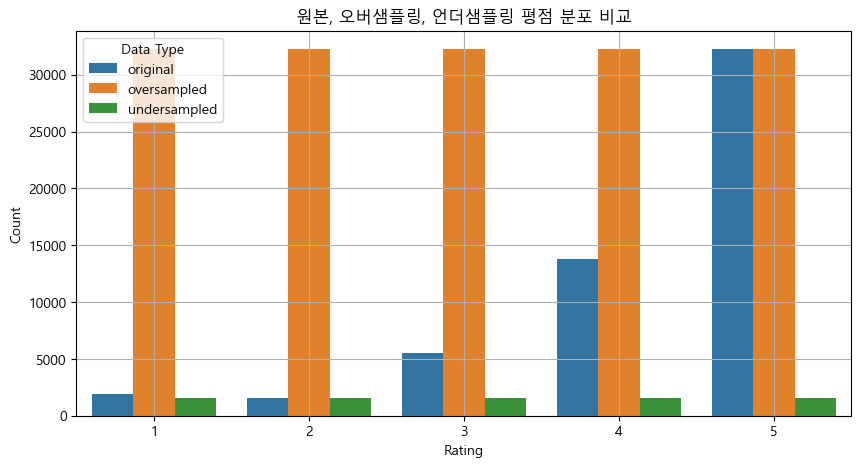

 원본 데이터 성능:
RMSE: 0.8955
MAE:  0.6597


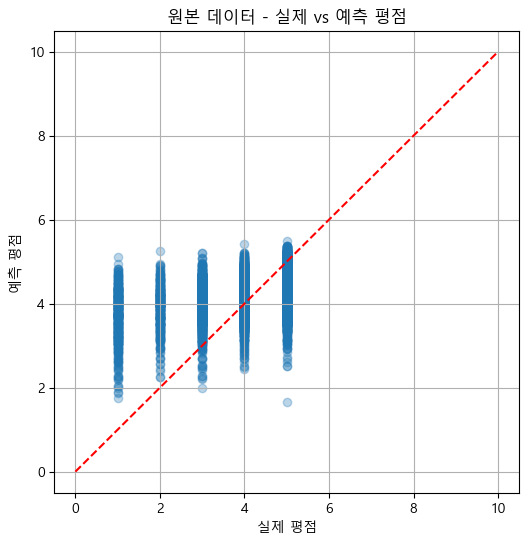

 오버샘플링 데이터 성능:
RMSE: 0.5523
MAE:  0.3392


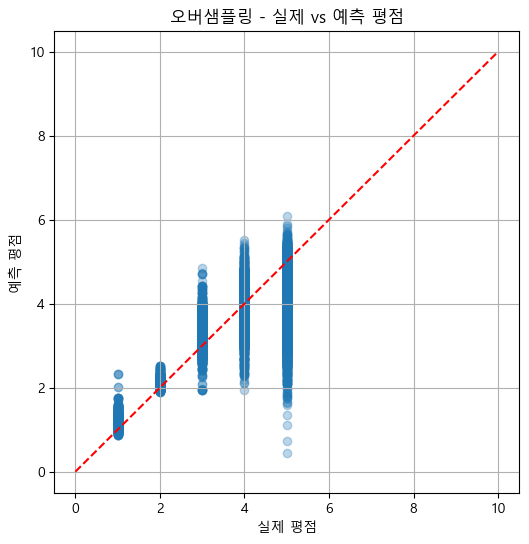

 언더샘플링 데이터 성능:
RMSE: 1.2438
MAE:  1.0538


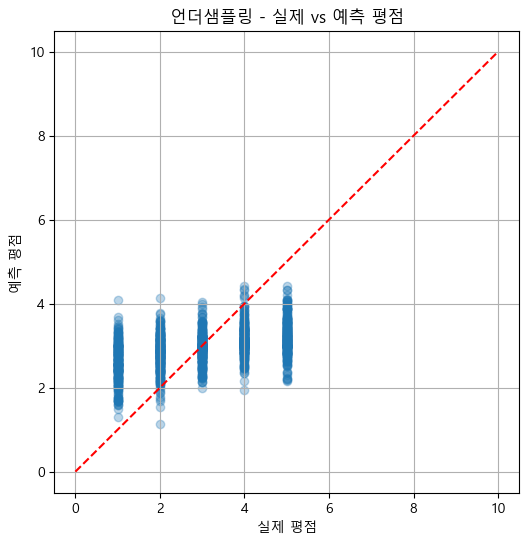


 결과 요약
원본 RMSE: 0.8955, MAE: 0.6597
오버샘플링 RMSE: 0.5523, MAE: 0.3392
언더샘플링 RMSE: 1.2438, MAE: 1.0538

 예시용 user_id 목록:
['보슬비' '책읽는나무' '코코몽' 'the' 'appletreeje' '초딩' '노말이' '기억의집' '쥬' '잘잘라']


In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
# 한글 폰트
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv("화요일_전처리.csv", encoding='utf-8', low_memory=False)

#  오버샘플링
max_size = df['rating'].value_counts().max()
lst_over = [df]
for class_index, group in df.groupby('rating'):
    lst_over.append(group.sample(max_size - len(group), replace=True, random_state=42))
df_over = pd.concat(lst_over)

#  언더샘플링
min_size = df['rating'].value_counts().min()
df_under = df.groupby('rating').apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)

#  시각화용 source 컬럼 추가
df['source'] = 'original'
df_over['source'] = 'oversampled'
df_under['source'] = 'undersampled'

df_all = pd.concat([df, df_over, df_under])

# 평점 분포 시각화
plt.figure(figsize=(10, 5))
sns.countplot(x='rating', hue='source', data=df_all)
plt.title("원본, 오버샘플링, 언더샘플링 평점 분포 비교")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.legend(title="Data Type")
plt.grid(True)
plt.show()

#  SVD 학습 및 평가 함수
def train_and_evaluate(df_input, title='모델 평가'):
    reader = Reader(rating_scale=(0, 10))
    data = Dataset.load_from_df(df_input[['user_id', 'isbn', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    model = SVD(n_factors=50, random_state=42)
    model.fit(trainset)

    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([0, 10], [0, 10], 'r--')
    plt.xlabel('실제 평점')
    plt.ylabel('예측 평점')
    plt.title(f'{title} - 실제평 예측 평점')
    plt.grid(True)
    plt.show()

    return model, rmse, mae

#  추천 Top-N 출력 함수
def recommend_top_n(model, df_input, user_id, n=10, isbn_to_title=None):
    read_books = df_input[df_input['user_id'] == user_id]['isbn'].unique()
    all_books = df_input['isbn'].unique()
    unread_books = [isbn for isbn in all_books if isbn not in read_books]

    preds = [model.predict(user_id, str(isbn)) for isbn in unread_books]
    top_n = sorted(preds, key=lambda x: x.est, reverse=True)[:n]

    print(f"\n[추천 결과] 사용자 {user_id}에게 추천 Top-{n}")
    for pred in top_n:
        title = isbn_to_title.get(pred.iid, "제목 없음") if isbn_to_title else pred.iid
        print(f"책 제목: {title}, ISBN: {pred.iid}, 예상 평점: {pred.est:.2f}")

#  SVD 학습 및 평가 실행
print(" 원본 데이터 성능:")
model_original, rmse_original, mae_original = train_and_evaluate(df, '원본 데이터')

print(" 오버샘플링 데이터 성능:")
model_over, rmse_over, mae_over = train_and_evaluate(df_over, '오버샘플링')

print(" 언더샘플링 데이터 성능:")
model_under, rmse_under, mae_under = train_and_evaluate(df_under, '언더샘플링')

#  결과 요약 출력
print(f"\n 결과 요약")
print(f"원본 RMSE: {rmse_original:.4f}, MAE: {mae_original:.4f}")
print(f"오버샘플링 RMSE: {rmse_over:.4f}, MAE: {mae_over:.4f}")
print(f"언더샘플링 RMSE: {rmse_under:.4f}, MAE: {mae_under:.4f}")

#  추천 Top-N 테스트
# isbn → title 딕셔너리 만들기
isbn_to_title = df.set_index('isbn')['title'].to_dict()

# user_id 확인
print("\n 예시용 user_id 목록:")
print(df['user_id'].unique()[:10])  # 첫 10명 출력

# 추천 호출 (예시 user_id 입력)
# 예) recommend_top_n(model_over, df_over, user_id='12345', n=10, isbn_to_title=isbn_to_title)


In [8]:
#  강한 필터링 적용
# 유저 최소 10권 이상 읽은 경우만
user_counts = df_over['user_id'].value_counts()
df_filtered = df_over[df_over['user_id'].isin(user_counts[user_counts >= 10].index)]

# 책 최소 10명 이상 평점 받은 경우만
isbn_counts = df_filtered['isbn'].value_counts()
df_filtered = df_filtered[df_filtered['isbn'].isin(isbn_counts[isbn_counts >= 10].index)]

# 필터링 후 현황 출력
print(f" 필터링 후 유저 수: {df_filtered['user_id'].nunique()}")
print(f" 필터링 후 책 수: {df_filtered['isbn'].nunique()}")

#  SVD 학습 (n_factors=100)
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_filtered[['user_id', 'isbn', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD(n_factors=100, random_state=42)
# model = SVD(
#     n_factors=100,
#     n_epochs=60,
#     lr_all=0.001,
#     reg_all=0.09
# )
model.fit(trainset)

# 추천 Top-N → ISBN 리스트만 출력
def recommend_top_n_isbn(model, df_input, user_id, n=10):
    read_books = df_input[df_input['user_id'] == user_id]['isbn'].unique()
    all_books = df_input['isbn'].unique()
    unread_books = [isbn for isbn in all_books if isbn not in read_books]

    preds = [model.predict(user_id, str(isbn)) for isbn in unread_books]
    top_n = sorted(preds, key=lambda x: x.est, reverse=True)[:n]

    recommended_isbns = [pred.iid for pred in top_n]

    print(f"\n[추천 결과] 사용자 {user_id}에게 추천 Top-{n} (ISBN 리스트)")
    print(recommended_isbns)

    return recommended_isbns

# user_id 확인 후 추천 테스트
print("\n 예시용 user_id 목록 (강한 필터링 후):")
print(df_filtered['user_id'].unique()[:10])  # 첫 10명 출력

# 예시 호출 → 여러 유저 테스트 권장
# 예) recommend_top_n_isbn(model, df_filtered, user_id='보슬비', n=10)
# 예) recommend_top_n_isbn(model, df_filtered, user_id='초딩', n=10)
# 예) recommend_top_n_isbn(model, df_filtered, user_id='기억의집', n=10)
# 예) recommend_top_n_isbn(model, df_filtered, user_id='세명', n=10)


 필터링 후 유저 수: 3691
 필터링 후 책 수: 1966

 예시용 user_id 목록 (강한 필터링 후):
['보슬비' '책읽는나무' '코코몽' 'the' 'appletreeje' '초딩' '노말이' '기억의집' '쥬' '잘잘라']


In [9]:
recommend_top_n_isbn(model, df_filtered, user_id='보슬비', n=10)
recommend_top_n_isbn(model, df_filtered, user_id='초딩', n=10)
recommend_top_n_isbn(model, df_filtered, user_id='기억의집', n=10)
recommend_top_n_isbn(model, df_filtered, user_id='세명', n=10)


[추천 결과] 사용자 보슬비에게 추천 Top-10 (ISBN 리스트)
['9788954682152', '9788936434595', '9788998441012', '9788954651134', '9788932024639', '9788937473401', '9788925554990', '9788954616515', '9791130642574', '9788983711892']

[추천 결과] 사용자 초딩에게 추천 Top-10 (ISBN 리스트)
['9788954682152', '9788936434595', '9788998441012', '9788954651134', '9788932024639', '9788937473401', '9788925554990', '9788954616515', '9791130642574', '9788983711892']

[추천 결과] 사용자 기억의집에게 추천 Top-10 (ISBN 리스트)
['9788954682152', '9788936434595', '9788998441012', '9788954651134', '9788932024639', '9788937473401', '9788925554990', '9788954616515', '9791130642574', '9788983711892']

[추천 결과] 사용자 세명에게 추천 Top-10 (ISBN 리스트)
['9788936434120', '9788954682152', '9788936434595', '9788998441012', '9788954651134', '9788932024639', '9788937473401', '9788925554990', '9788954616515', '9791130642574']


['9788936434120',
 '9788954682152',
 '9788936434595',
 '9788998441012',
 '9788954651134',
 '9788932024639',
 '9788937473401',
 '9788925554990',
 '9788954616515',
 '9791130642574']

In [ ]:
--------------

pip install sentence-transformers

In [10]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

#  모델 로드
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')
# https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2

#  책별 review 임베딩 만들기
# (review가 null이면 빈 문자열 처리)
df_filtered['review'] = df_filtered['review'].fillna('')
book_reviews = df_filtered.groupby('isbn')['review'].apply(lambda x: ' '.join(x)).reset_index()

# 임베딩 추출
book_reviews['embedding'] = book_reviews['review'].apply(lambda x: model.encode(x))

# isbn → embedding dict
isbn_to_embedding = dict(zip(book_reviews['isbn'].astype(str), book_reviews['embedding']))

#  유저 embedding 만들기 → 유저가 읽은 책들의 embedding 평균
def get_user_embedding(user_id):
    read_books = df_filtered[df_filtered['user_id'] == user_id]['isbn'].unique()
    read_embeddings = [isbn_to_embedding[str(isbn)] for isbn in read_books if str(isbn) in isbn_to_embedding]

    if len(read_embeddings) == 0:
        return None

    user_embedding = np.mean(read_embeddings, axis=0)
    return user_embedding

#  추천 Top-N (embedding 기반 cosine similarity)
def recommend_hybrid_top_n(user_id, n=10):
    user_emb = get_user_embedding(user_id)
    if user_emb is None:
        print(f" 사용자 {user_id}는 학습된 embedding 없음")
        return []

    # 안읽은 책만 추천 대상
    read_books = df_filtered[df_filtered['user_id'] == user_id]['isbn'].unique()
    unread_isbns = [isbn for isbn in isbn_to_embedding.keys() if isbn not in read_books.astype(str)]

    # cosine similarity 계산
    sims = []
    for isbn in unread_isbns:
        sim = cosine_similarity([user_emb], [isbn_to_embedding[isbn]])[0][0]
        sims.append((isbn, sim))

    # Top-N 반환
    top_n = sorted(sims, key=lambda x: x[1], reverse=True)[:n]
    recommended_isbns = [isbn for isbn, _ in top_n]

    print(f"\n[Hybrid 추천 결과] 사용자 {user_id} Top-{n} (ISBN 리스트)")
    print(recommended_isbns)

    return recommended_isbns

#  추천 테스트 예시
recommend_hybrid_top_n(user_id='보슬비', n=10)
recommend_hybrid_top_n(user_id='초딩', n=10)
recommend_hybrid_top_n(user_id='기억의집', n=10)
recommend_hybrid_top_n(user_id='세명', n=10)



[Hybrid 추천 결과] 사용자 보슬비 Top-10 (ISBN 리스트)
['9791187498100', '9788994343921', '9788985712682', '9791160486735', '9791185014562', '9788992555531', '9788984372757', '9788937473197', '9788936472016', '9788954653848']

[Hybrid 추천 결과] 사용자 초딩 Top-10 (ISBN 리스트)
['9788936472016', '9788954613392', '9788970128719', '9791191587524', '9788954625470', '9788984372757', '9788901280684', '9788936456221', '9791196075170', '9788984989146']

[Hybrid 추천 결과] 사용자 기억의집 Top-10 (ISBN 리스트)
['9791196394509', '9788936472016', '9788991147768', '9791197021688', '9788954611275', '9788991622869', '9788954637237', '9788934923503', '9788954621496', '9791190413152']
 사용자 세명는 학습된 embedding 없음


[]

In [27]:
def recommend_hybrid_top_n_with_score(user_id, n=10):
    user_emb = get_user_embedding(user_id)
    if user_emb is None:
        print(f" 사용자 {user_id}는 학습된 embedding 없음")
        return []

    read_books = df_filtered[df_filtered['user_id'] == user_id]['isbn'].unique()
    unread_isbns = [isbn for isbn in isbn_to_embedding.keys() if isbn not in read_books.astype(str)]

    sims = []
    for isbn in unread_isbns:
        sim = cosine_similarity([user_emb], [isbn_to_embedding[isbn]])[0][0]
        sims.append((isbn, sim))

    top_n = sorted(sims, key=lambda x: x[1], reverse=True)[:n]

    print(f"\n[Hybrid 추천 결과 + 유사도] 사용자 {user_id} Top-{n}")
    for isbn, score in top_n:
        print(f"ISBN: {isbn}, similarity: {score:.4f}")

    return top_n


In [28]:
recommend_hybrid_top_n_with_score("보슬비",n=10)


[Hybrid 추천 결과 + 유사도] 사용자 보슬비 Top-10
ISBN: 9791187498100, similarity: 0.8109
ISBN: 9788994343921, similarity: 0.8095
ISBN: 9788985712682, similarity: 0.8069
ISBN: 9791160486735, similarity: 0.8065
ISBN: 9791185014562, similarity: 0.8044
ISBN: 9788992555531, similarity: 0.8042
ISBN: 9788984372757, similarity: 0.8003
ISBN: 9788937473197, similarity: 0.8001
ISBN: 9788936472016, similarity: 0.7921
ISBN: 9788954653848, similarity: 0.7911


[('9791187498100', 0.8109197),
 ('9788994343921', 0.8095269),
 ('9788985712682', 0.80687183),
 ('9791160486735', 0.80650496),
 ('9791185014562', 0.80438536),
 ('9788992555531', 0.80421597),
 ('9788984372757', 0.80025584),
 ('9788937473197', 0.8001056),
 ('9788936472016', 0.7921052),
 ('9788954653848', 0.7911137)]

In [29]:
import json

def recommend_hybrid_top_n_json(user_id, n=10):
    top_n = recommend_hybrid_top_n_with_score(user_id, n)
    
    result = [
        {
            'isbn': isbn,
            'similarity': float(f"{score:.4f}")
        }
        for isbn, score in top_n
    ]

    json_result = json.dumps(result, ensure_ascii=False, indent=2)
    print(f"\n[Hybrid 추천 결과] 사용자 {user_id} Top-{n} (JSON)")
    print(json_result)

    return json_result


In [30]:
recommend_hybrid_top_n_json('보슬비', n = 10)


[Hybrid 추천 결과 + 유사도] 사용자 보슬비 Top-10
ISBN: 9791187498100, similarity: 0.8109
ISBN: 9788994343921, similarity: 0.8095
ISBN: 9788985712682, similarity: 0.8069
ISBN: 9791160486735, similarity: 0.8065
ISBN: 9791185014562, similarity: 0.8044
ISBN: 9788992555531, similarity: 0.8042
ISBN: 9788984372757, similarity: 0.8003
ISBN: 9788937473197, similarity: 0.8001
ISBN: 9788936472016, similarity: 0.7921
ISBN: 9788954653848, similarity: 0.7911

[Hybrid 추천 결과] 사용자 보슬비 Top-10 (JSON)
[
  {
    "isbn": "9791187498100",
    "similarity": 0.8109
  },
  {
    "isbn": "9788994343921",
    "similarity": 0.8095
  },
  {
    "isbn": "9788985712682",
    "similarity": 0.8069
  },
  {
    "isbn": "9791160486735",
    "similarity": 0.8065
  },
  {
    "isbn": "9791185014562",
    "similarity": 0.8044
  },
  {
    "isbn": "9788992555531",
    "similarity": 0.8042
  },
  {
    "isbn": "9788984372757",
    "similarity": 0.8003
  },
  {
    "isbn": "9788937473197",
    "similarity": 0.8001
  },
  {
    "isbn": "97

'[\n  {\n    "isbn": "9791187498100",\n    "similarity": 0.8109\n  },\n  {\n    "isbn": "9788994343921",\n    "similarity": 0.8095\n  },\n  {\n    "isbn": "9788985712682",\n    "similarity": 0.8069\n  },\n  {\n    "isbn": "9791160486735",\n    "similarity": 0.8065\n  },\n  {\n    "isbn": "9791185014562",\n    "similarity": 0.8044\n  },\n  {\n    "isbn": "9788992555531",\n    "similarity": 0.8042\n  },\n  {\n    "isbn": "9788984372757",\n    "similarity": 0.8003\n  },\n  {\n    "isbn": "9788937473197",\n    "similarity": 0.8001\n  },\n  {\n    "isbn": "9788936472016",\n    "similarity": 0.7921\n  },\n  {\n    "isbn": "9788954653848",\n    "similarity": 0.7911\n  }\n]'

In [32]:
import pickle

# 저장
with open('isbn_to_embedding.pkl', 'wb') as f:
    pickle.dump(isbn_to_embedding, f)
print(" 임베딩 캐싱 저장 완료 (isbn_to_embedding.pkl)")

# 불러오기
with open('isbn_to_embedding.pkl', 'rb') as f:
    isbn_to_embedding = pickle.load(f)
print(" 임베딩 캐싱 불러오기 완료")


 임베딩 캐싱 저장 완료 (isbn_to_embedding.pkl)
 임베딩 캐싱 불러오기 완료


In [36]:
# SVD 모델이 이미 학습된 상태에서 사용 (model = SVD(...) → model.fit(trainset))

# Hybrid blending 추천 함수
def recommend_blended_top_n(user_id, n=10, alpha=0.8, beta=0.2):
    # 사용자 embedding
    user_emb = get_user_embedding(user_id)
    if user_emb is None:
        print(f" 사용자 {user_id}는 학습된 embedding 없음")
        return []

    # 읽은 책 제외
    read_books = df_filtered[df_filtered['user_id'] == user_id]['isbn'].unique()
    unread_isbns = [isbn for isbn in isbn_to_embedding.keys() if isbn not in read_books.astype(str)]

    results = []

    for isbn in unread_isbns:
        # SVD 예측
        svd_pred = model.predict(user_id, str(isbn)).est  # SVD predicted rating

        # LLM cosine similarity
        llm_sim = cosine_similarity([user_emb], [isbn_to_embedding[isbn]])[0][0]

        # Blended score 계산
        final_score = alpha * svd_pred + beta * llm_sim

        results.append((isbn, svd_pred, llm_sim, final_score))

    # Top-N 선정
    top_n = sorted(results, key=lambda x: x[3], reverse=True)[:n]

    # 결과 출력
    print(f"\n[Blended 추천 결과] 사용자 {user_id} Top-{n} (α={alpha}, β={beta})")
    for isbn, svd_pred, llm_sim, final_score in top_n:
        print(f"ISBN: {isbn}, SVD_pred: {svd_pred:.2f}, LLM_sim: {llm_sim:.4f}, Final_score: {final_score:.4f}")

    return top_n


In [37]:
# 예시 호출
recommend_blended_top_n(user_id='보슬비', n=10, alpha=0.8, beta=0.2)
recommend_blended_top_n(user_id='초딩', n=10, alpha=0.8, beta=0.2)
recommend_blended_top_n(user_id='기억의집', n=10, alpha=0.8, beta=0.2)
recommend_blended_top_n(user_id='세명', n=10, alpha=0.8, beta=0.2)



[Blended 추천 결과] 사용자 보슬비 Top-10 (α=0.8, β=0.2)
ISBN: 9791187498100, SVD_pred: 3.20, LLM_sim: 0.8109, Final_score: 2.7248
ISBN: 9788994343921, SVD_pred: 3.20, LLM_sim: 0.8095, Final_score: 2.7245
ISBN: 9788985712682, SVD_pred: 3.20, LLM_sim: 0.8069, Final_score: 2.7240
ISBN: 9791160486735, SVD_pred: 3.20, LLM_sim: 0.8065, Final_score: 2.7239
ISBN: 9791185014562, SVD_pred: 3.20, LLM_sim: 0.8044, Final_score: 2.7235
ISBN: 9788992555531, SVD_pred: 3.20, LLM_sim: 0.8042, Final_score: 2.7235
ISBN: 9788984372757, SVD_pred: 3.20, LLM_sim: 0.8003, Final_score: 2.7227
ISBN: 9788937473197, SVD_pred: 3.20, LLM_sim: 0.8001, Final_score: 2.7226
ISBN: 9788936472016, SVD_pred: 3.20, LLM_sim: 0.7921, Final_score: 2.7210
ISBN: 9788954653848, SVD_pred: 3.20, LLM_sim: 0.7911, Final_score: 2.7208

[Blended 추천 결과] 사용자 초딩 Top-10 (α=0.8, β=0.2)
ISBN: 9788936472016, SVD_pred: 3.00, LLM_sim: 0.7389, Final_score: 2.5473
ISBN: 9788954613392, SVD_pred: 3.00, LLM_sim: 0.7242, Final_score: 2.5443
ISBN: 9788970128719

[]

In [39]:
def recommend_blended_top_n(user_id, n=10, alpha=0.8, beta=0.2):
    user_emb = get_user_embedding(user_id)

    read_books = df_filtered[df_filtered['user_id'] == user_id]['isbn'].unique()
    unread_isbns = [isbn for isbn in isbn_to_embedding.keys() if isbn not in read_books.astype(str)]

    results = []

    # Case Hybrid 추천 (embedding 있음)
    if user_emb is not None:
        for isbn in unread_isbns:
            svd_pred = model.predict(user_id, str(isbn)).est
            llm_sim = cosine_similarity([user_emb], [isbn_to_embedding[isbn]])[0][0]
            final_score = alpha * svd_pred + beta * llm_sim
            results.append((isbn, svd_pred, llm_sim, final_score))

        top_n = sorted(results, key=lambda x: x[3], reverse=True)[:n]

        print(f"\n[Blended 추천 결과] 사용자 {user_id} Top-{n} (α={alpha}, β={beta})")
        for isbn, svd_pred, llm_sim, final_score in top_n:
            print(f"ISBN: {isbn}, SVD_pred: {svd_pred:.2f}, LLM_sim: {llm_sim:.4f}, Final_score: {final_score:.4f}")

    # Case  Fallback → SVD만 추천
    else:
        print(f"\사용자 {user_id}는 embedding 없음 → SVD 추천만 사용합니다")
        for isbn in unread_isbns:
            svd_pred = model.predict(user_id, str(isbn)).est
            results.append((isbn, svd_pred))

        top_n = sorted(results, key=lambda x: x[1], reverse=True)[:n]

        print(f"\n[SVD Fallback 추천 결과] 사용자 {user_id} Top-{n}")
        for isbn, svd_pred in top_n:
            print(f"ISBN: {isbn}, SVD_pred: {svd_pred:.2f}")

    return top_n


In [40]:
recommend_blended_top_n(user_id='보슬비', n=10)
recommend_blended_top_n(user_id='초딩', n=10)
recommend_blended_top_n(user_id='기억의집', n=10)
recommend_blended_top_n(user_id='세명', n=10)



[Blended 추천 결과] 사용자 보슬비 Top-10 (α=0.8, β=0.2)
ISBN: 9791187498100, SVD_pred: 3.20, LLM_sim: 0.8109, Final_score: 2.7248
ISBN: 9788994343921, SVD_pred: 3.20, LLM_sim: 0.8095, Final_score: 2.7245
ISBN: 9788985712682, SVD_pred: 3.20, LLM_sim: 0.8069, Final_score: 2.7240
ISBN: 9791160486735, SVD_pred: 3.20, LLM_sim: 0.8065, Final_score: 2.7239
ISBN: 9791185014562, SVD_pred: 3.20, LLM_sim: 0.8044, Final_score: 2.7235
ISBN: 9788992555531, SVD_pred: 3.20, LLM_sim: 0.8042, Final_score: 2.7235
ISBN: 9788984372757, SVD_pred: 3.20, LLM_sim: 0.8003, Final_score: 2.7227
ISBN: 9788937473197, SVD_pred: 3.20, LLM_sim: 0.8001, Final_score: 2.7226
ISBN: 9788936472016, SVD_pred: 3.20, LLM_sim: 0.7921, Final_score: 2.7210
ISBN: 9788954653848, SVD_pred: 3.20, LLM_sim: 0.7911, Final_score: 2.7208

[Blended 추천 결과] 사용자 초딩 Top-10 (α=0.8, β=0.2)
ISBN: 9788936472016, SVD_pred: 3.00, LLM_sim: 0.7389, Final_score: 2.5473
ISBN: 9788954613392, SVD_pred: 3.00, LLM_sim: 0.7242, Final_score: 2.5443
ISBN: 9788970128719

[('8809332970027', 2.9336271734735138),
 ('8809332970874', 2.9336271734735138),
 ('9788901033518', 2.9336271734735138),
 ('9788901035208', 2.9336271734735138),
 ('9788901036373', 2.9336271734735138),
 ('9788901044873', 2.9336271734735138),
 ('9788901047799', 2.9336271734735138),
 ('9788901047904', 2.9336271734735138),
 ('9788901049847', 2.9336271734735138),
 ('9788901052922', 2.9336271734735138)]

In [43]:
import json

def recommend_blended_top_n_json(user_id, n=10, alpha=0.8, beta=0.2):
    user_emb = get_user_embedding(user_id)

    read_books = df_filtered[df_filtered['user_id'] == user_id]['isbn'].unique()
    unread_isbns = [isbn for isbn in isbn_to_embedding.keys() if isbn not in read_books.astype(str)]

    results = []

    # Case  Hybrid 추천 (embedding 있음)
    if user_emb is not None:
        for isbn in unread_isbns:
            svd_pred = model.predict(user_id, str(isbn)).est
            llm_sim = cosine_similarity([user_emb], [isbn_to_embedding[isbn]])[0][0]

            final_score = alpha * svd_pred + beta * float(llm_sim)  # float() 적용

            results.append({
                'isbn': isbn,
                'svd_pred': round(svd_pred, 2),
                'llm_sim': round(float(llm_sim), 4),  # float() 적용
                'final_score': round(final_score, 4)
            })

        top_n = sorted(results, key=lambda x: x['final_score'], reverse=True)[:n]

        print(f"\n[Blended 추천 결과 + JSON] 사용자 {user_id} Top-{n} (α={alpha}, β={beta})")
        print(json.dumps(top_n, ensure_ascii=False, indent=2))

    # Case  Fallback → SVD만 추천
    else:
        print(f"\n 사용자 {user_id}는 embedding 없음 → SVD 추천만 사용합니다")
        for isbn in unread_isbns:
            svd_pred = model.predict(user_id, str(isbn)).est
            results.append({
                'isbn': isbn,
                'svd_pred': round(svd_pred, 2)
            })

        top_n = sorted(results, key=lambda x: x['svd_pred'], reverse=True)[:n]

        print(f"\n[SVD Fallback 추천 결과 + JSON] 사용자 {user_id} Top-{n}")
        print(json.dumps(top_n, ensure_ascii=False, indent=2))

    # JSON 객체 반환
    return json.dumps(top_n, ensure_ascii=False, indent=2)


In [44]:
# JSON 결과 확인
json_result = recommend_blended_top_n_json(user_id='보슬비', n=10)

# 필요 시 → 프론트에 json_result 반환 가능
# Django API에서는 return Response(json_result, content_type='application/json') 형태로 사용



[Blended 추천 결과 + JSON] 사용자 보슬비 Top-10 (α=0.8, β=0.2)
[
  {
    "isbn": "9791187498100",
    "svd_pred": 3.2,
    "llm_sim": 0.8109,
    "final_score": 2.7248
  },
  {
    "isbn": "9788994343921",
    "svd_pred": 3.2,
    "llm_sim": 0.8095,
    "final_score": 2.7245
  },
  {
    "isbn": "9788985712682",
    "svd_pred": 3.2,
    "llm_sim": 0.8069,
    "final_score": 2.724
  },
  {
    "isbn": "9791160486735",
    "svd_pred": 3.2,
    "llm_sim": 0.8065,
    "final_score": 2.7239
  },
  {
    "isbn": "9788992555531",
    "svd_pred": 3.2,
    "llm_sim": 0.8042,
    "final_score": 2.7235
  },
  {
    "isbn": "9791185014562",
    "svd_pred": 3.2,
    "llm_sim": 0.8044,
    "final_score": 2.7235
  },
  {
    "isbn": "9788984372757",
    "svd_pred": 3.2,
    "llm_sim": 0.8003,
    "final_score": 2.7227
  },
  {
    "isbn": "9788937473197",
    "svd_pred": 3.2,
    "llm_sim": 0.8001,
    "final_score": 2.7226
  },
  {
    "isbn": "9788936472016",
    "svd_pred": 3.2,
    "llm_sim": 0.7921,
    

In [ ]:
# views.py

from django.http import JsonResponse
import json

# Hybrid 추천기 함수 사용 (지금 만든 recommend_blended_top_n_json 함수 그대로 사용)
# 이 함수는 문자열(JSON)을 반환하므로 → JsonResponse에 다시 파싱 필요

def recommend_view(request, user_id):
    n = int(request.GET.get('n', 10))  # URL 파라미터로 n 개수 받기 (기본 10개)

    # 추천 결과 얻기
    result_json_str = recommend_blended_top_n_json(user_id=user_id, n=n)

    # 문자열 JSON → dict 변환
    result_json = json.loads(result_json_str)

    # API 응답
    return JsonResponse(result_json, safe=False, json_dumps_params={'ensure_ascii': False, 'indent': 2})


In [ ]:
# urls.py

from django.urls import path
from . import views

urlpatterns = [
    path('recommend/<str:user_id>/', views.recommend_view, name='recommend'),
]


In [ ]:
# 호출예시
GET /recommend/보슬비/?n=10
